* Nesse projeto eu uso dados do satelite S-NPP coletados do site da nasa para validar uma noticia publicada pela CNN Brasil sobre o aumento de focos de incendios entre os meses de janeiro a agorsto do ano de 2021 comparado com o mesmo periodo do ano de 2020.

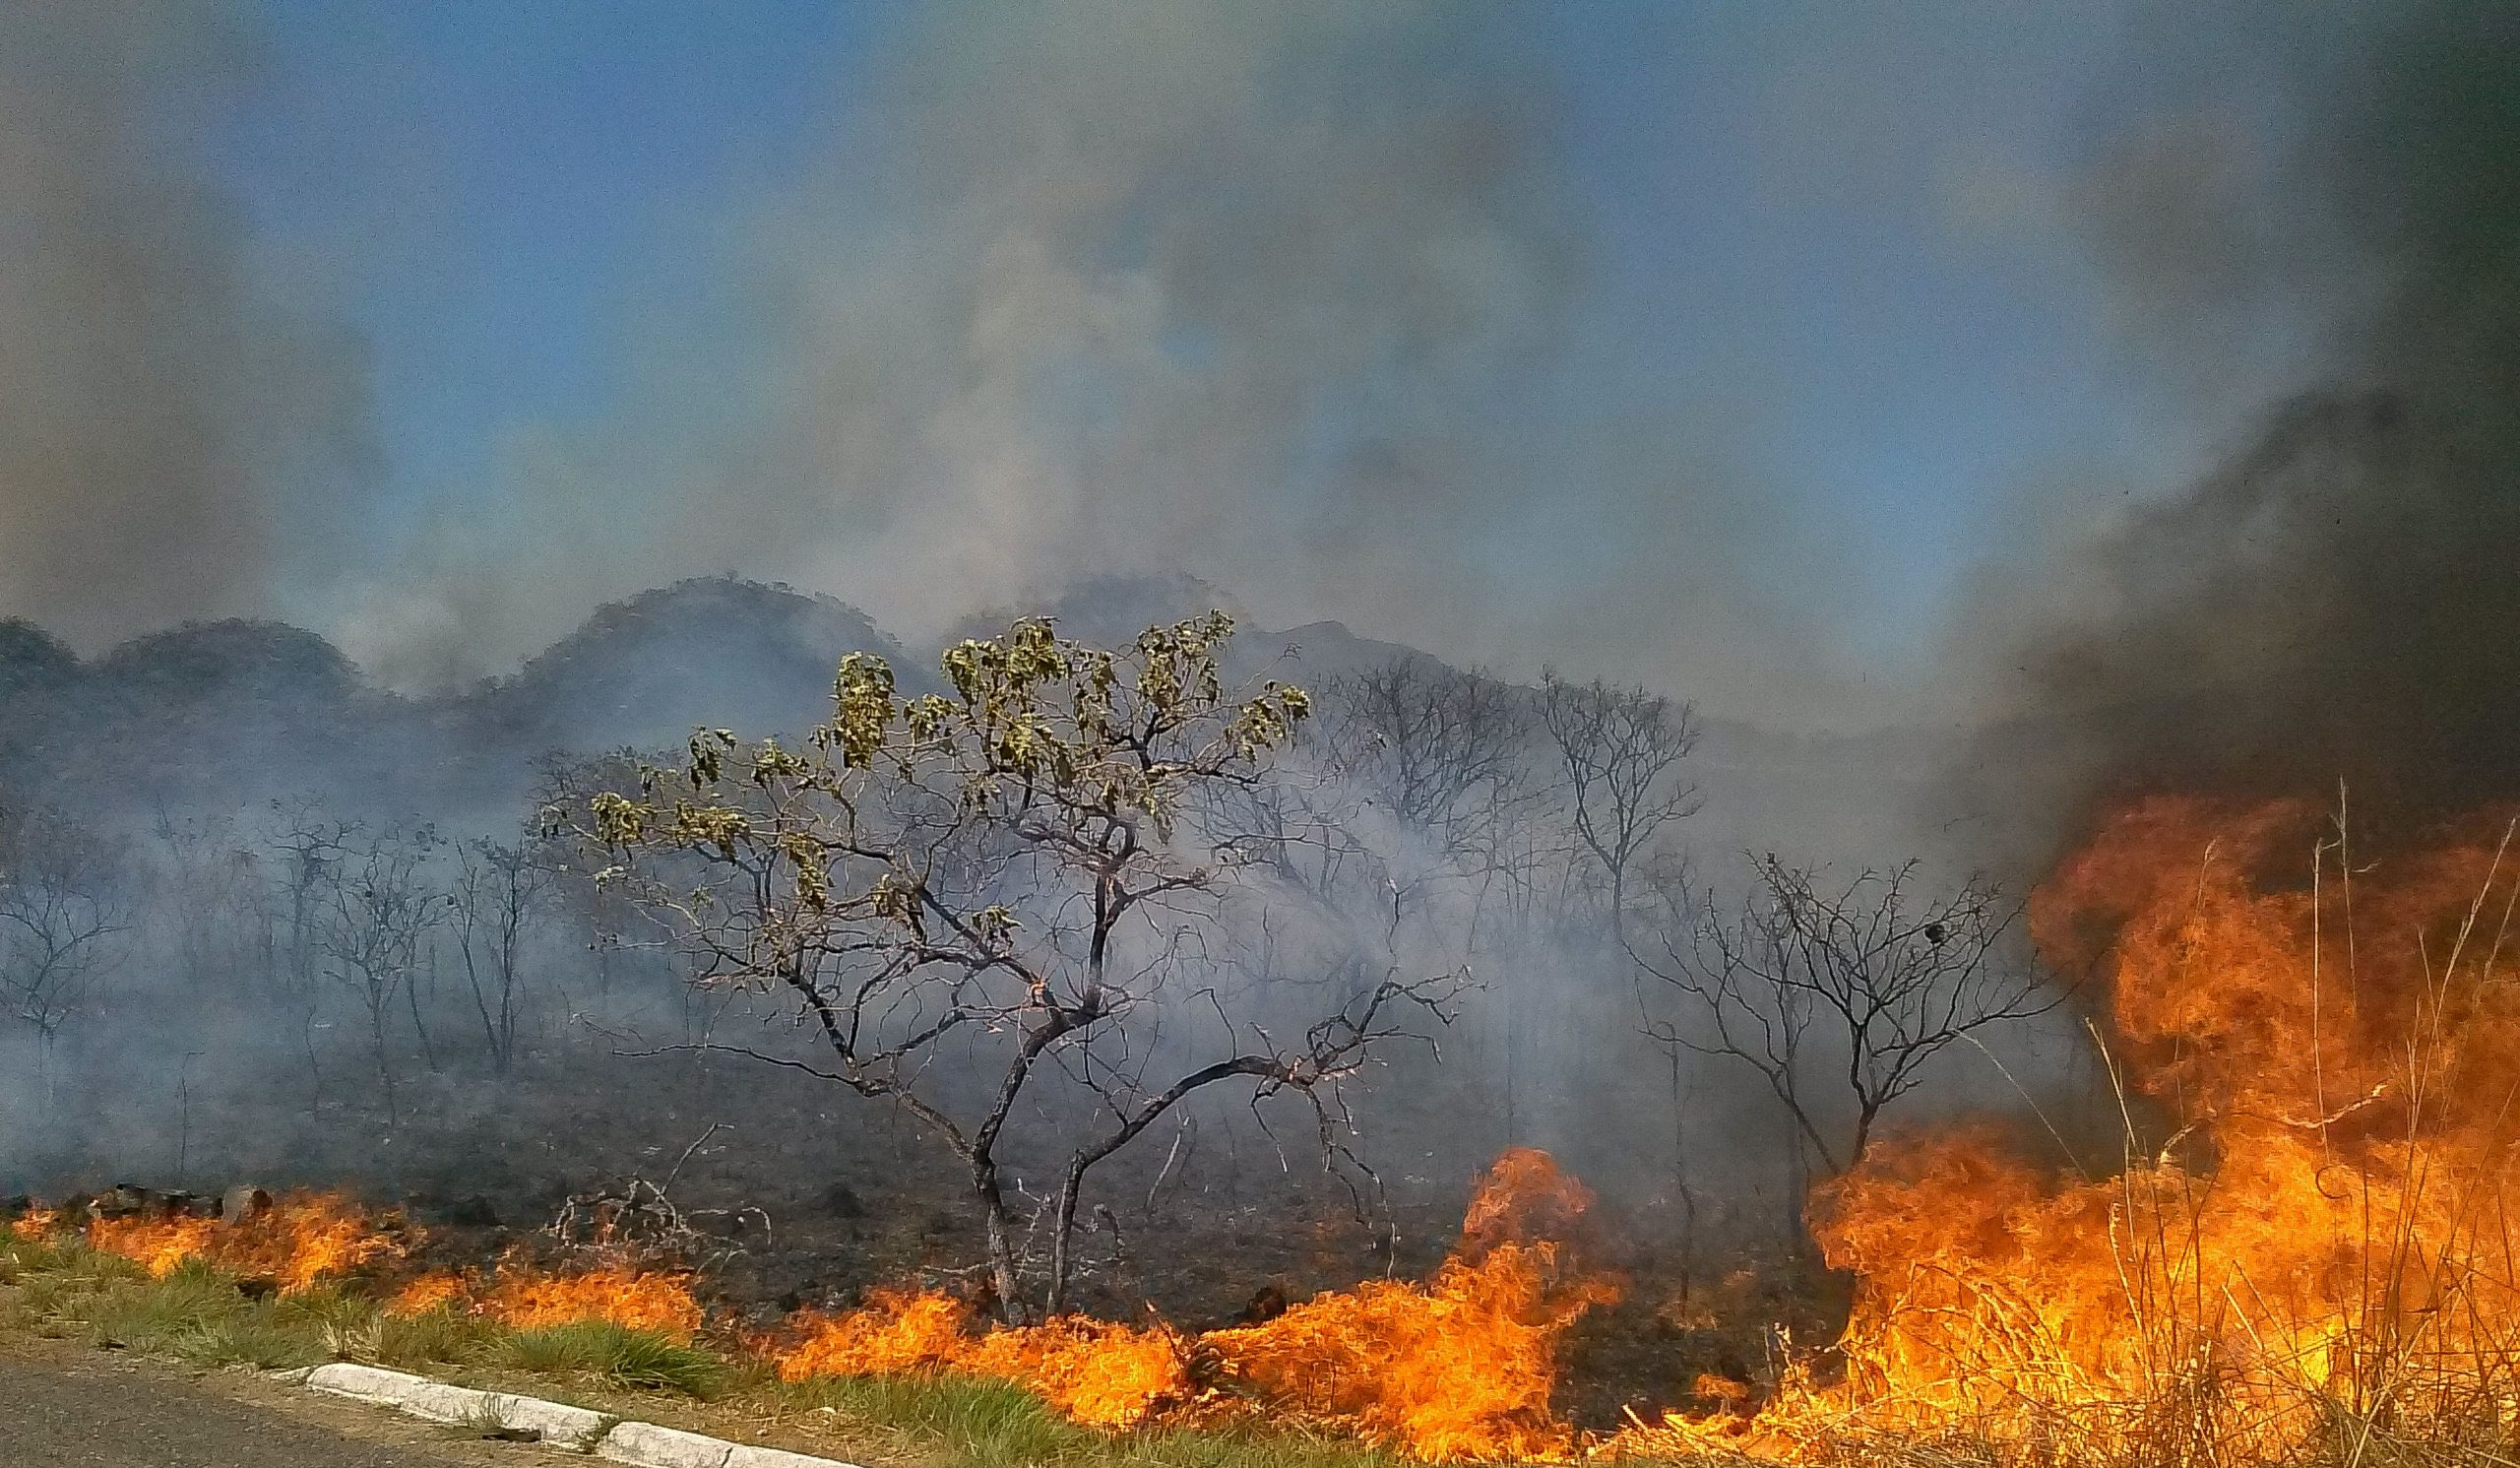

In [13]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import folium
from folium import plugins
import pydeck as pdk
import plotly.offline as py
from mpl_toolkits.basemap import Basemap
from datetime import datetime as dt
import cufflinks as cf
cf.go_offline()
import sweetviz as sv
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Carregando o dataset.
incendios_df = pd.read_csv('/home/eduardo/projetos/analise_queimadas/incendios_mes.csv')

In [15]:
# Visualisando as 5 primeiras linhas do dataset.
incendios_df.head()

mes_fire   latitude  longitude  brightness  scan  track    acq_date  \
0  2020-01  -4.634367 -44.920513      330.36  0.39   0.36  2020-01-01   
1  2020-01  -4.634920 -44.917027      308.77  0.39   0.36  2020-01-01   
2  2020-01 -17.749628 -42.892834      319.87  0.52   0.42  2020-01-01   
3  2020-01 -19.058695 -42.941364      303.55  0.54   0.42  2020-01-01   
4  2020-01 -17.131834 -56.512676      313.63  0.35   0.57  2020-01-01   

   acq_time satellite instrument confidence  version  bright_t31   frp  \
0       418         N      VIIRS          n        1      282.50  3.16   
1       418         N      VIIRS          n        1      282.10  1.22   
2       418         N      VIIRS          n        1      288.60  2.50   
3       418         N      VIIRS          n        1      288.86  0.75   
4       418         N      VIIRS          n        1      280.71  1.63   

  daynight  type  
0        N     0  
1        N     0  
2        N     0  
3        N     0  
4        N     0

In [16]:
# Verificando o tamanho do dataset.
incendios_df.shape

(2985749, 16)

In [17]:
# Verificando as informações gerais do dataset.
incendios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985749 entries, 0 to 2985748
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   mes_fire    object 
 1   latitude    float64
 2   longitude   float64
 3   brightness  float64
 4   scan        float64
 5   track       float64
 6   acq_date    object 
 7   acq_time    int64  
 8   satellite   object 
 9   instrument  object 
 10  confidence  object 
 11  version     int64  
 12  bright_t31  float64
 13  frp         float64
 14  daynight    object 
 15  type        int64  
dtypes: float64(7), int64(3), object(6)
memory usage: 364.5+ MB


In [18]:
# Verificando se existem dados faltantes no dataset.
incendios_df.isna().sum()

mes_fire      0
latitude      0
longitude     0
brightness    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_t31    0
frp           0
daynight      0
type          0
dtype: int64

#### Visualisando as variaveis de dada e hora.

#### O grafico abaixo mostra como os focos de incendios se comportam no decorrer dos meses.

In [20]:
focos_por_mes = incendios_df.pivot_table('brightness', 'mes_fire', aggfunc='count')

In [21]:
focos_por_mes = focos_por_mes.reset_index()

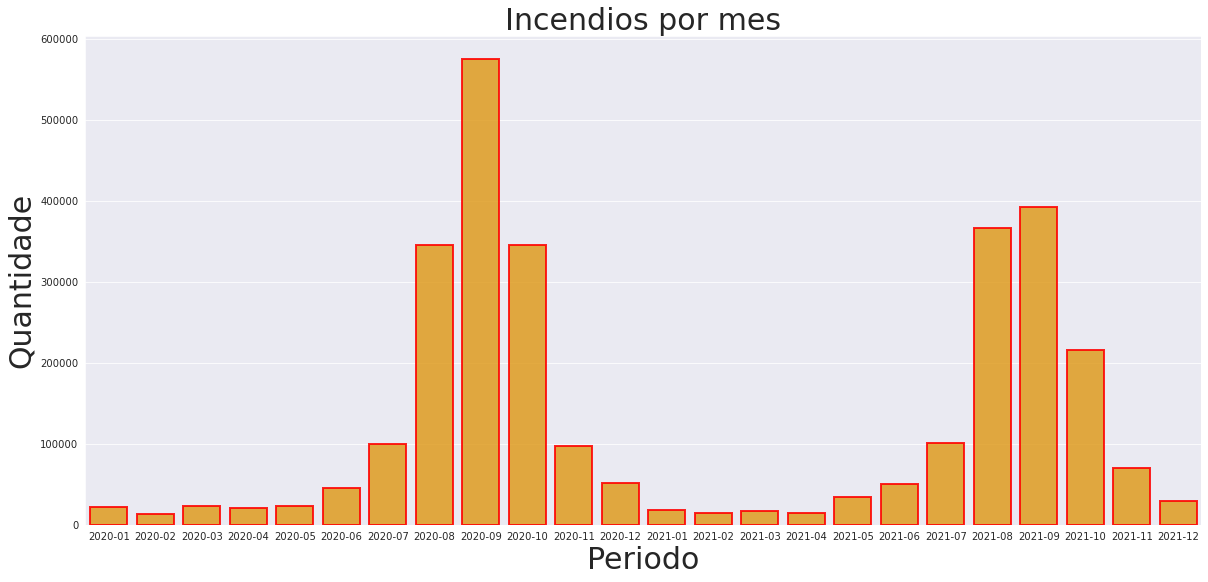

In [22]:
plt.figure(figsize=(20,9))
plt.title('Incendios por mes', fontsize=30)
plt.ylabel('Incendios', fontsize=30)
sns.barplot(data=focos_por_mes, x='mes_fire', y='brightness', ci=None, alpha=0.85, edgecolor="red", linewidth=2, color='orange')
plt.xlabel('Periodo', fontsize=30)
plt.ylabel('Quantidade', fontsize=30)
plt.show()

#### Os meses com as maiores ocorrencias de incendios estao entre agosto e outubro, o que faz sentido por se tratar de periodos de seca no pais. Ja as menores ocorrencias se concentram mais no inicio e no final do ano por se tratarem de periodos mais chuvosos.

In [24]:
incendios_df.head(2)

mes_fire  latitude  longitude  brightness  scan  track    acq_date  \
0  2020-01 -4.634367 -44.920513      330.36  0.39   0.36  2020-01-01   
1  2020-01 -4.634920 -44.917027      308.77  0.39   0.36  2020-01-01   

   acq_time satellite instrument confidence  version  bright_t31   frp  \
0       418         N      VIIRS          n        1       282.5  3.16   
1       418         N      VIIRS          n        1       282.1  1.22   

  daynight  type  
0        N     0  
1        N     0

##### A variavel "acq_time" nao esta em um formato de hora como pode ser visto na celula acima, e após deduzir que por exemplo "418" na verdade seria "04:18", criei uma função pra corrigir isso.

In [25]:
def transform_str(valor):
    transformed = str(valor).zfill(4)
    return transformed[0:2] + ':' + transformed[2:]

In [26]:
incendios_df['acq_time'] = incendios_df.acq_time.apply(transform_str)

In [27]:
incendios_df.head(2)

mes_fire  latitude  longitude  brightness  scan  track    acq_date acq_time  \
0  2020-01 -4.634367 -44.920513      330.36  0.39   0.36  2020-01-01    04:18   
1  2020-01 -4.634920 -44.917027      308.77  0.39   0.36  2020-01-01    04:18   

  satellite instrument confidence  version  bright_t31   frp daynight  type  
0         N      VIIRS          n        1       282.5  3.16        N     0  
1         N      VIIRS          n        1       282.1  1.22        N     0

#### Pra reforçar minha hipotese sobre o formato das horas criei uma função pra checar a consistencia dos minutos.

In [28]:
def verfica_minutos(valor):
    minutos = valor[3:]
    minutos = valor.split(':')[1]
    return int(minutos) >= 60

In [29]:
incendios_df['consistencia_minutos'] = incendios_df.acq_time.apply(verfica_minutos)

In [30]:
incendios_df.query('consistencia_minutos == True').shape[0]

0

#### A função reafirma que realmente as horas apareciam naquela formatação por estarem no formato inteiro, mas pra descartar qualquer duvida chequei o mapa dos horarios que o satelite passou pelo Brasil naquele periodo e realmente as horas batem com o dataset e isso confirma que a minha interpretação esta correta.
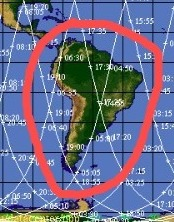

#### Criando uma nova coluna somente com as informações das horas.

In [31]:
def get_hora(valor):
    hora = valor[:2]
    hora = valor.split(':')[0]
    return hora

In [32]:
incendios_df['hora'] = incendios_df.acq_time.apply(get_hora)

In [40]:
incendios_df.head(2)

mes_fire  latitude  longitude  brightness  scan  track    acq_date acq_time  \
0  2020-01 -4.634367 -44.920513      330.36  0.39   0.36  2020-01-01    04:18   
1  2020-01 -4.634920 -44.917027      308.77  0.39   0.36  2020-01-01    04:18   

  satellite instrument confidence  version  bright_t31   frp daynight  type  \
0         N      VIIRS          n        1       282.5  3.16        N     0   
1         N      VIIRS          n        1       282.1  1.22        N     0   

   consistencia_minutos hora  
0                 False   04  
1                 False   04

In [38]:
incendios_df.hora.min(), incendios_df.hora.max()

('02', '19')

#### De acordo com informacoes do INPE, O S-NPP passa sobre o Brasil e parte da América do Sul aproximadamente no horário das05 às 06 UTC (madrugada) e das 17 às 18 UTC (tarde). O que faz sentido sobre o horario minimo e maximo da variavel “hora“ 

#### Quantidade de incendios ocorridos por hora.

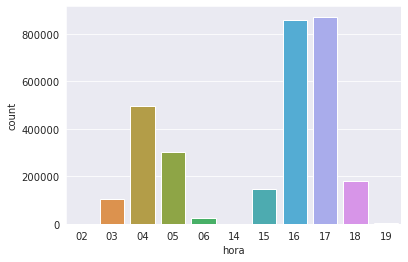

In [34]:
sns.countplot(x="hora", data=incendios_df);

#### Podemos ver no grafico que os maiores casos de incendios ocorrem no periodo entre 16h e 17h.

#### Distribuição das variaveis quantitativas.

<AxesSubplot:xlabel='brightness'>

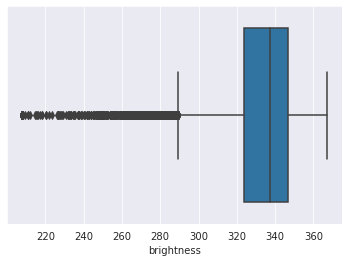

In [16]:
sns.boxplot(x = 'brightness', data=incendios_df)

#### Analisando a variavel "brightness", a temperatura varia entre 285 e 365 kelvin.

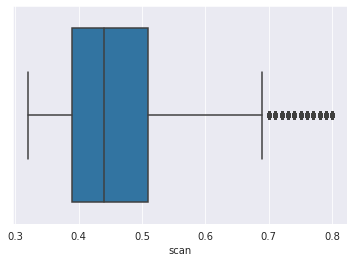

In [43]:
sns.boxplot(x = 'scan', data=incendios_df);

#### Analisando a variavel "scan", a varredura varia entre 0.3 e 0.7.

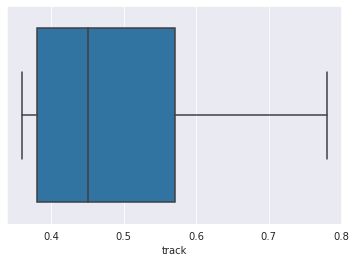

In [44]:
sns.boxplot(x = 'track', data=incendios_df);

#### Analisando a variavel "track", a varredura varia entre 0.3 e 0.8.

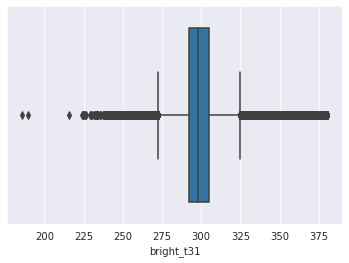

In [45]:
sns.boxplot(x = 'bright_t31', data=incendios_df);

#### Analisando a variavel "bright_t31", a temperatura varia entre 275 e 325 kelvin.

#### Distribuição das variaveis qualitativas.

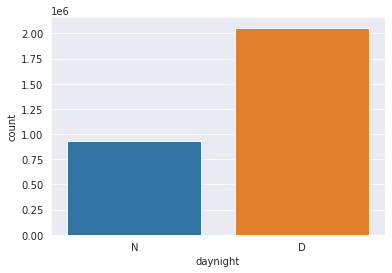

In [24]:
sns.countplot(x = incendios_df["daynight"]);

#### Analisando a variavel "daynight" que corresponde a quantidade de focos de incendios ocorridos durante a noite e durante o dia,  pode ser observado no grafico que os maiores focos ocorrem durante o dia.

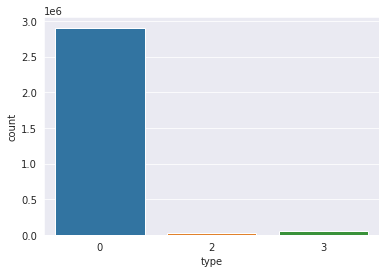

In [25]:
sns.countplot(x = incendios_df["type"]);

#### A variavel "type" corresponde aos locais onde os focos de incendios foram detectados.
* Tipo "0" = incendios ocorridos em vegetações.
* Tipo "2" = incendios ocorridos em outras fontes de terra estatica.
* Tipo "3" = incendios ocorridos no mar.

#### Com issso podemos observar claramente no grafico que a grande maioria dos focos são em vegetações.


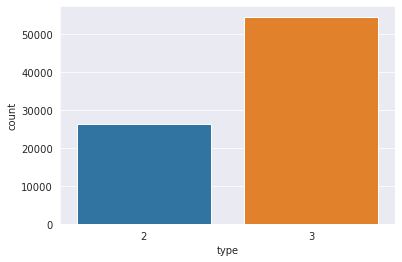

In [42]:
sns.countplot(x= 'type', data= incendios_df.loc[incendios_df['type'] != 0]);

#### Fazendo uma analise apenas com os focos de incendios ocorridos em outra parte estatica da terra e no mar, podemos observar no grafico que ainda temos uma quantidade significativa de incendios nesses pontos, tendo uma concentracao maior no mar.

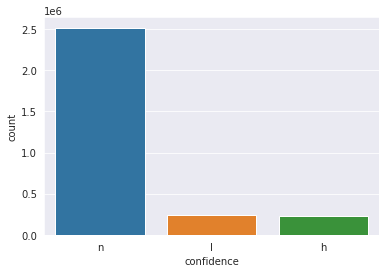

In [30]:
sns.countplot(x = incendios_df["confidence"]);

#### A varivel "confidence" corresponde ao grau de confiança de que o algoritmo tem sobre ser ou não um foco de incendio.
* n = confiança nominal.
* l = baixa confiança.
* h = alta confiança.

#### No grafico podemos ver que a maior parte é de confiança nominal. 

#### Distribuição das variaveis de acordo com a intensidade dos focos de incendios.

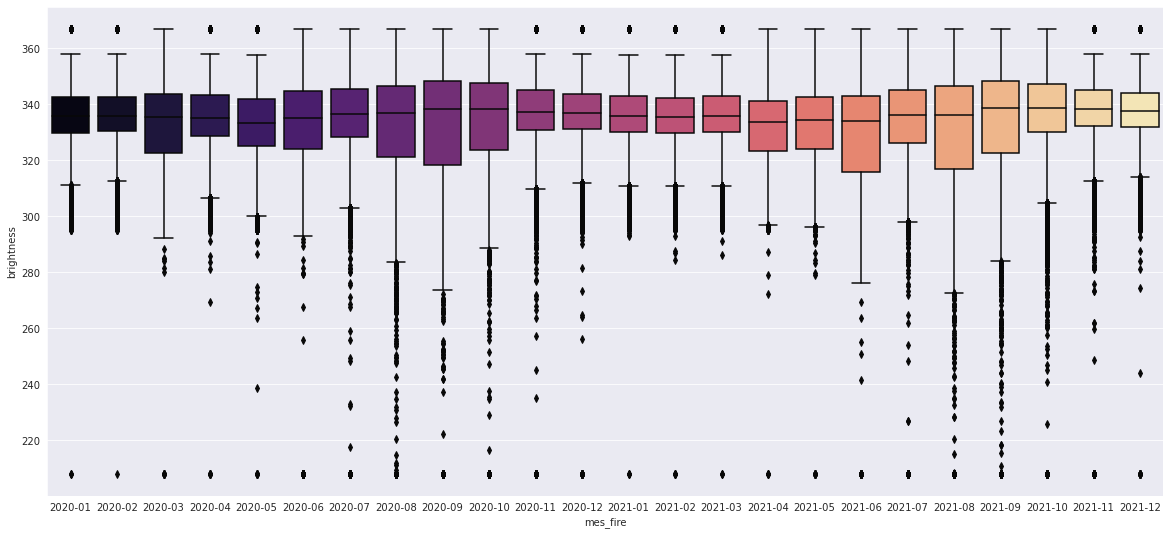

In [7]:
plt.figure(figsize=(20,9))
sns.boxplot(x = incendios_df['mes_fire'],y = incendios_df['brightness'], color ='#35c279',
                palette = "magma")
plt.axis('on')
plt.show()

#### Analisando os meses com a variavel "brightness" a temperatura de brilho varia entre 270 e 360 kelvin e apresenta bastante outliers com temperaturas de brilho mais baixas, pricipalmente nos periodos de agosto a novembro

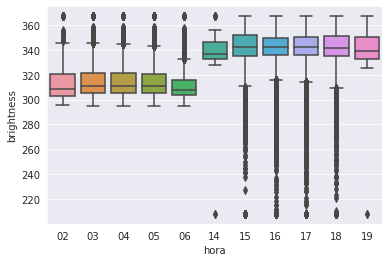

In [39]:
sns.boxplot(x="hora", y="brightness", data=incendios_df);

#### Incendios com maior intensidade ocorrem no periodo entre 14h e 19h.

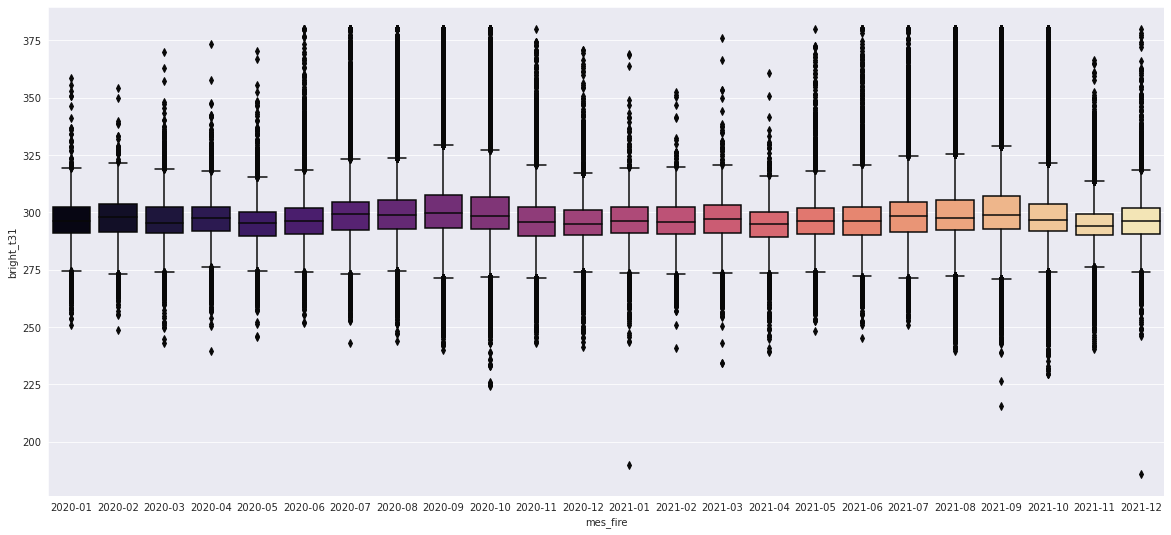

In [8]:
plt.figure(figsize=(20,9))
sns.boxplot(x = incendios_df['mes_fire'],y = incendios_df['bright_t31'], color ='#35c279',
                palette = "magma")
plt.axis('on')
plt.show()

#### Analisando os meses com a variavel "bright_t31" a temperatura de brilho varia entre 275 e 325 kelvin.

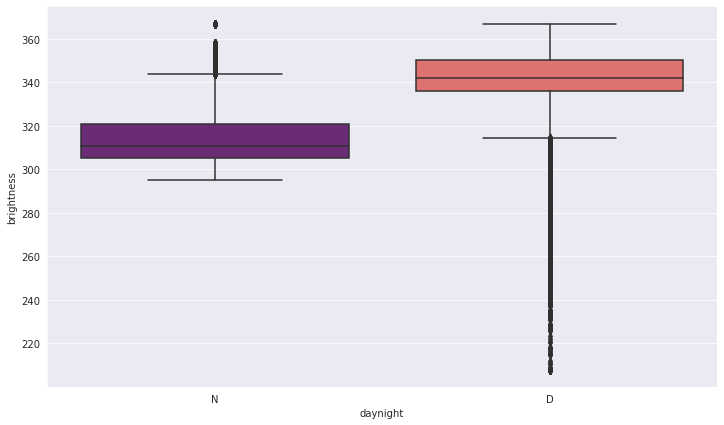

In [9]:
plt.figure(figsize=(12,7))
sns.boxplot(x = incendios_df['daynight'],y = incendios_df['brightness'], color ='#35c279',
                palette = "magma")
plt.axis('on')
plt.show()

#### Analisando as variaveis "daynight" e "brightness" a temperatura de brilho durante a noite varia entre 300 e 340 kelvin e durante o dia varia entre 315 e 360 kelvin. Nota-se tambem uma grande quantidade de exceções de focos com baixa intensidade durante o dia, o que pode ser ocorrido pelo fato de interferencias de raios solares que prejudicam a interpretação do algoritmo.

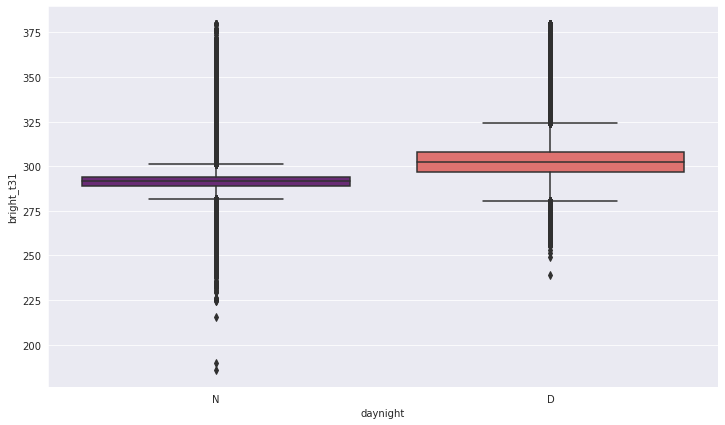

In [10]:
plt.figure(figsize=(12,7))
sns.boxplot(x = incendios_df['daynight'],y = incendios_df['bright_t31'], color ='#35c279',
                palette = "magma")
plt.axis('on')
plt.show()

#### Analisando as variaveis "daynight" e "bright_t31" a temperatura de brilho durante a noite varia entre 280 e 300 kelvin e durante o dia fica entre 280 e 325 kelvin.

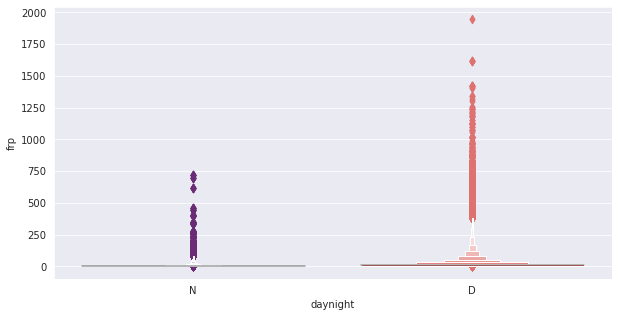

In [42]:
plt.figure(figsize=(10,5))
sns.boxenplot(x = incendios_df['daynight'],y = incendios_df['frp'], color ='#35c279',
                palette = "magma")
plt.axis('on')
plt.show()

#### Analisando as variaveis "daynight" e "frp" a temperatura de brilho durante a noite varia bem proximo de zero e durante o dia fica entre 0 e 100 kelvin. Sabendo que o "frp" captura pequenos focos de incendios faz sentido as temperaturas bem baixas.

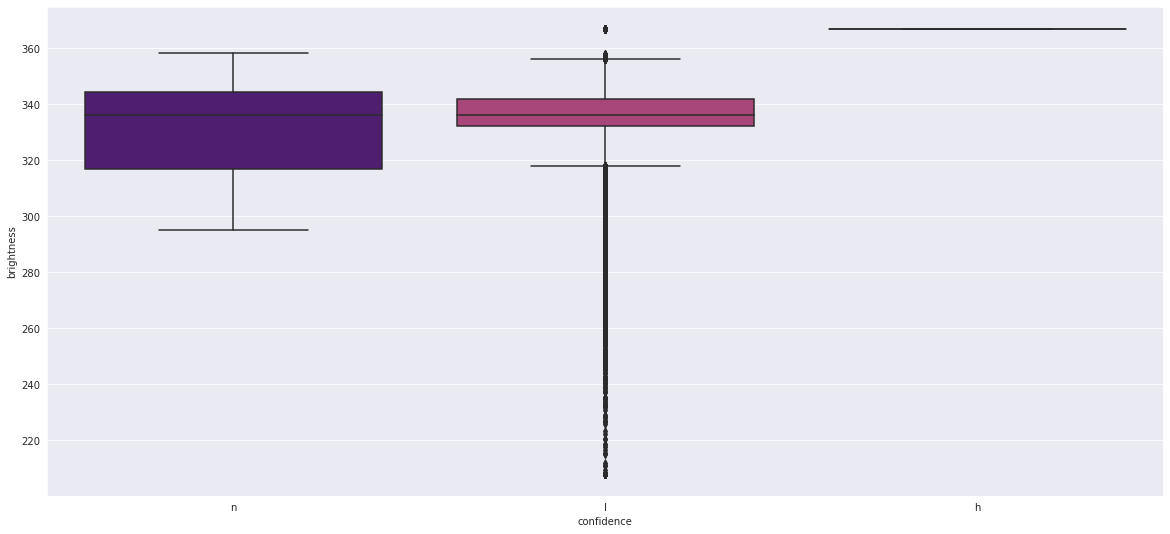

In [12]:
plt.figure(figsize=(20,9))
sns.boxplot(x = incendios_df['confidence'],y = incendios_df['brightness'], color ='#35c279',
                palette = "magma")
plt.axis('on')
plt.show()

#### Analisando as variaveis "confidence" e "brightness" a temperatura de brilho de confiança nominal varia entre 300 e 360 kelvin, enquanto a temperatura de brilho de baixa confiança varia entre 320 e 360 kelvin e ja a temperatura de alta confiança varia acima de 360 kelvin. Tambem se nota a quantidade de autliers com focos de menos intensidade na detecção de baixa confiança que tbm pode ter sido causada pela interferencia de raios solares na detecção do algoritmo.

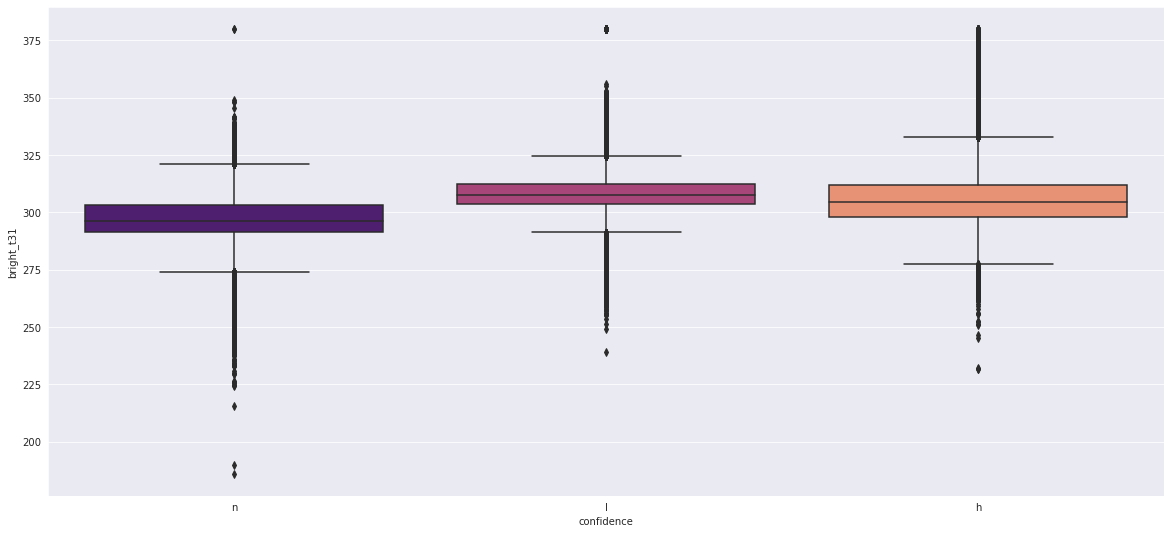

In [13]:
plt.figure(figsize=(20,9))
sns.boxplot(x = incendios_df['confidence'],y = incendios_df['bright_t31'], color ='#35c279',
                palette = "magma")
plt.axis('on')
plt.show()

#### Analisando as variaveis "confidence" e "bright_t31" a temperatura de brilho de confiança nominal varia entre 275 e 325 kelvin, enquanto a temperatura de brilho de baixa confiança varia entre 290 e 325 kelvin e ja a temperatura de alta confiança varia entre 275 e 330 kelvin.

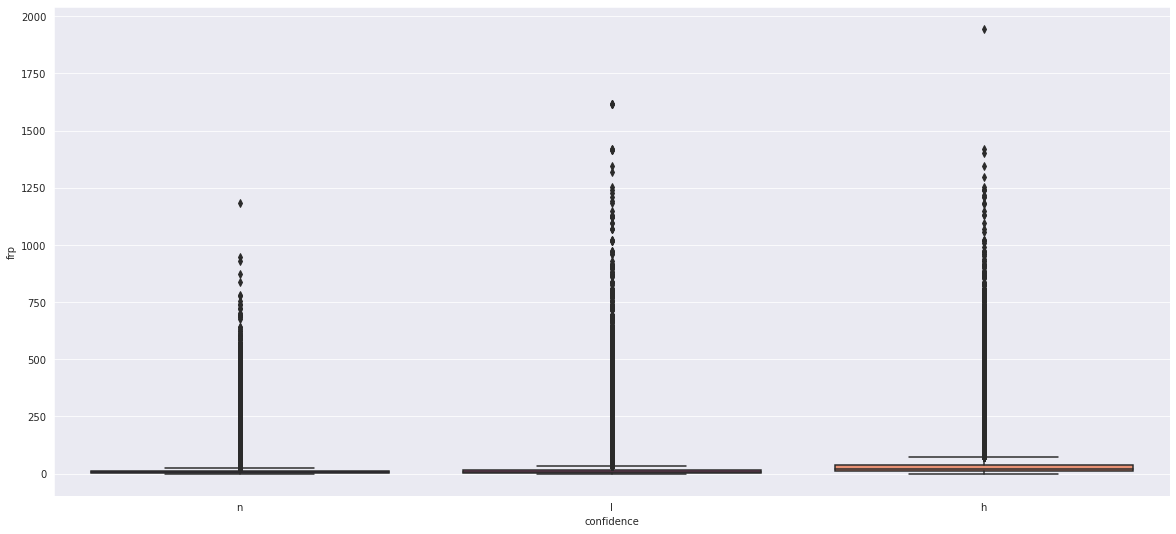

In [14]:
plt.figure(figsize=(20,9))
sns.boxplot(x = incendios_df['confidence'],y = incendios_df['frp'], color ='#35c279',
                palette = "magma")
plt.axis('on')
plt.show()

#### Analisando as variaveis "confidence" e "frp" a temperatura de brilhos tem variações bem baixas, ja que se deve ao fato de que o ''frp'' detecta apenas pequenos focos de incendios.

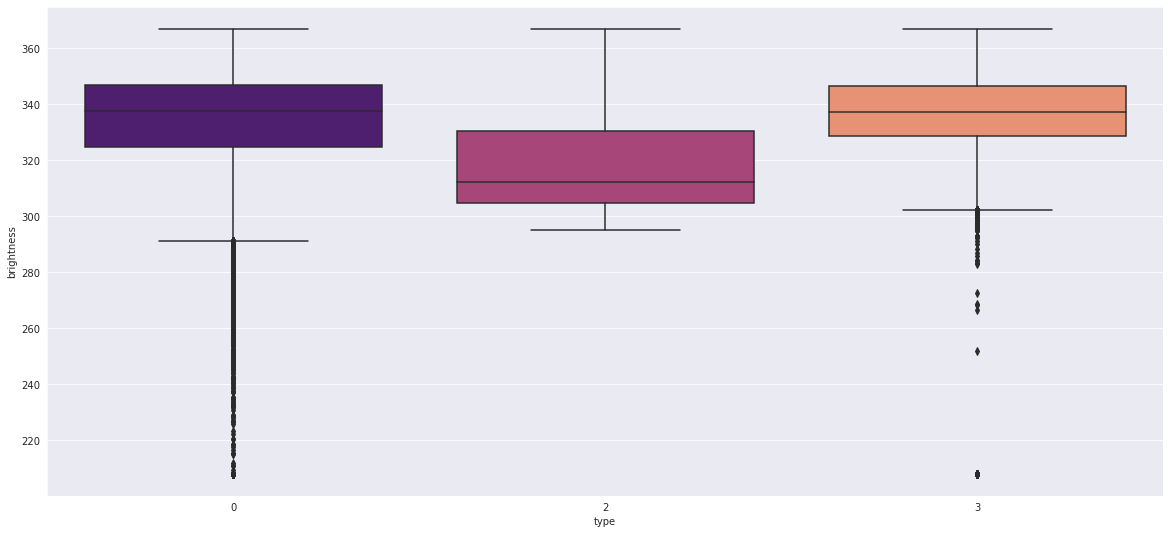

In [15]:
plt.figure(figsize=(20,9))
sns.boxplot(x = incendios_df['type'],y = incendios_df['brightness'], color ='#35c279',
                palette = "magma")
plt.axis('on')
plt.show()

#### Analisando os tipos de incendios do tipo 0 que corresponde aos incendios em vegetações a temperatura varia entre 290 e 365 kelvin, ja do tipo 2 que corresponde aos focos em outras fontes de terra estatica varia entre 295 e 365 e do tipo 3 que corresponde aos focos ocorridos no mar varia entre 300 e 365 kelvin.